# Perceptron from Scratch in Numpy

The classical Perceptron algorithm provides a simple and elegant procedure for learning a linear classifier. In each step, the algorithm observes the sample's position and label and may update the current predictor accordingly. [Arxiv](https://arxiv.org/abs/2008.01710)

Perceptron algorithm tries to find a hyperplane to separate our two classes. 

One of the main assumption that the algorithm makes is that the data should be linearly separable. If the assumption is violated, then the algorithm keeps trying to find a solution in vain.

## Generating the dataset

First let's create a binary classification dataset. 

Crucial thing here is the `parameter` - `how_far_away` - this parameter will allow us to create class distributions that are closer or further away from one another.

Let's take a look at how it controls the class seperation below.

In [1]:
import numpy as np

In [276]:
class Dataset:

  def __init__(self, n = 50, how_far_away = 0.8):
    n2 = int(n/2)
    n75 = int(n*0.75)
    dist = 50

    # Use Random Normal Data
    self.xa = np.random.normal(100 , 5 , (n2,2))
    self.xb = np.random.normal(100 + dist*how_far_away , 5 , (n2,2))
    self.x = np.concatenate((self.xa ,self.xb))

    ## Create labels
    self.y = np.concatenate((np.ones(n2) , -1*np.ones(n2)))
    self.train_idx = np.random.choice(np.arange(0,n) ,n75)

    ## Create train/test partitions
    self.x_train = self.x[self.train_idx]
    self.x_test = self.x[~self.train_idx]
    self.y_train = self.y[self.train_idx]
    self.y_test = self.y[~self.train_idx]


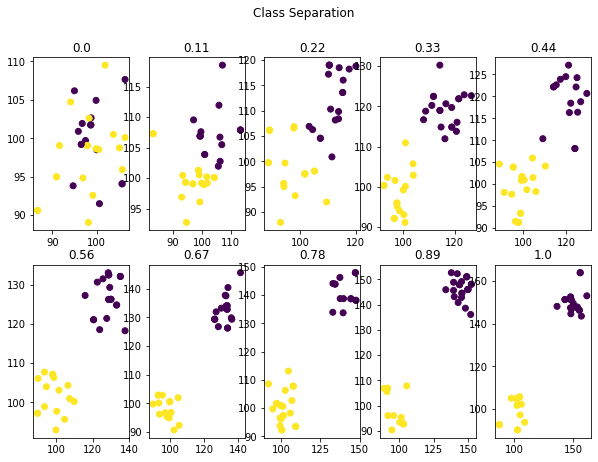

In [277]:
fig, ax = plt.subplots(nrows=2 , ncols=5, figsize=(10,7))
for i,s in enumerate(np.linspace(0,1,10)):
  di = Dataset(how_far_away = s)
  ax[int(i/5)][i% 5].scatter(di.x_train[:,0] , di.x_train[:,1] , c=di.y_train)
  ax[int(i/5)][i% 5].set_title(round(s , 2))

fig.suptitle("Class Separation")
plt.show()

We see that as `parameter` approaches `1` we get a very clear class separation , whereas when `parameter` is close to `0` then the class observations overall each other.

Now let's generate a dataset to work with.

In [161]:
dataset = Dataset()
dataset.x_train.shape

(37, 2)

In [162]:
import matplotlib.pyplot as plt

Let's visualize this dataset

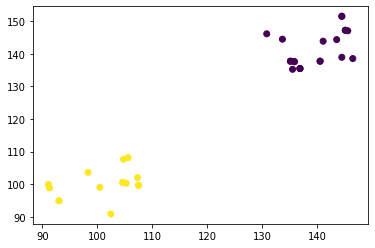

In [293]:
plt.scatter(dataset.x_train[:,0] , dataset.x_train[:,1] , c=dataset.y_train)

## Implementation

Now let's implement our `Peceptron` class.

The algorithm intuition is straightforward -

1. Initialize weights to `zero`
2. Go over each data point
  - If the point is on the correct side of the hyperplane then move on to the next point 
    - Else update the weights of the hyperplane using the update rule
3. Keep doing this until all points are on the correct side of the hyperplane

![image](https://user-images.githubusercontent.com/6872080/105902760-150d1980-5fed-11eb-8e4a-03fb8e059c6a.png)

[Source](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote03.html)

### Update rule

The update rule has a geometric interpretation based on vector calculations.

![image](https://user-images.githubusercontent.com/6872080/105903046-6ae1c180-5fed-11eb-882a-848c0c50e4d0.png)







In [294]:
class Perceptron:

  def find_margin(self, X):
    minidx = np.argmin(np.dot(np.reshape(self.weights , (1,-1)) , X.T))
    val = X[minidx]
    return np.linalg.norm(val , 2)

  def fit(self, X,y):
    X = np.hstack((X , np.ones((X.shape[0] , 1))))

    self.weights = np.zeros(X.shape[1])
    total_updates = 0

    while True:
      num_updates = 0
      for i,xi in enumerate(X):
        if np.dot(self.weights.T ,xi)*y[i] <= 0:
          self.weights += y[i]*xi
          num_updates += 1

      total_updates += num_updates

      if (num_updates == 0) :

        """
        Below three lines are just for tracking purpose 
        and not part of the core algorithm. 
        We can simply break when there are no updates
        """
        self.weight_seq.append(np.copy(self.weights))
        self.num_updates = total_updates
        self.margin = self.find_margin(X)
        break

Now let's train the `Perceptron`

In [285]:
perceptron = Perceptron()
perceptron.fit(dataset.x_train , dataset.y_train)

Let's take a look at the weights

In [286]:
perceptron.weights

array([  96.27680952, -150.83784421, 6720.        ])

To better understand the weights lets visualize the learn't hyperplane

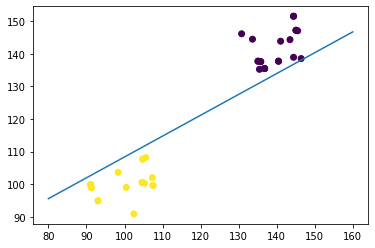

In [288]:
ws = perceptron.weights

def hyperplane(x ,ws):
  return (ws[0]*x + ws[2]) / -ws[1]

plt.scatter(dataset.x_train[:,0] , dataset.x_train[:,1] , c=dataset.y_train)
plt.plot([80,160] , [hyperplane(80 , ws) , hyperplane(160 , ws)])
plt.show()

### Experimentation

Now let's vary the class separation and look at 
1. How many updates the perceptron makes before finding the hyperplane
2. What is the maximum number of iterations after which the algorithm is bound to converge.

To do these experiments we vary the class separation from `0.6` to `1` and get 100 different datasets.

For each of those datasets we find 
1. The margin - which is the distance from the hyperplane to the closest data point.
2. The number of updates made

In [296]:
from plotnine import *
import pandas as pd

In [291]:
space = np.linspace(0.6 , 1 , 100)
results = np.zeros((space.shape[0] , 2))

for i,s in enumerate(space):
  d = Dataset(how_far_away=s)
  perceptron = Perceptron()
  perceptron.fit(d.x_train , d.y_train)
  results[i][0] = perceptron.margin
  results[i][1] = perceptron.num_updates

/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


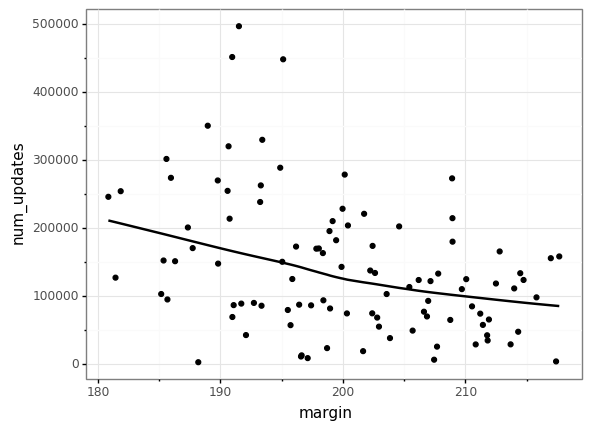

<ggplot: (8762263814678)>

In [298]:
(
    ggplot(pd.DataFrame({"margin" : results[: , 0] , "num_updates" : results[: , 1]}) , aes(x="margin" , y="num_updates"))
    + geom_point()
    + geom_smooth()
    + theme_bw()
)

As we see above, as the margin increases the number of updates needed before convergence decrease. Therefore if the classes are further apart from one another then the algorithm converges quickly, otherwise when classes are closer the algorithm takes longer.

[Proof of Bound on Number of Iterations](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote03.html)